In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import normaltest

pd.options.display.max_rows = 12
pd.options.display.max_columns = 5

In [2]:
#load the data
movies_df = pd.read_csv( "movie_metadata.csv" )

In [3]:
#drop labels we aren't interested in
movies_df.drop( labels = [ 'color', 'duration', 'facenumber_in_poster',
                          'plot_keywords', 'movie_imdb_link', 'imdb_score',
                          'movie_facebook_likes', 'content_rating',
                          'aspect_ratio', 'num_critic_for_reviews',
                          'num_user_for_reviews', 'budget', 'num_voted_users',
                          'cast_total_facebook_likes' ],
               axis = 1, inplace = True )

In [4]:
#rearrange column labels
movies_df = movies_df [ [ 'movie_title', 'title_year', 'country', 'language',
                         'gross', 'director_name', 'director_facebook_likes', 
                         'actor_1_name', 'actor_1_facebook_likes', 'actor_2_name',
                         'actor_2_facebook_likes', 'actor_3_name',
                         'actor_3_facebook_likes', 'genres' ] ]

In [5]:
#drop potential duplicates
movies_df.drop_duplicates(keep='first',inplace=True)
#drop movies that aren't in english
movies_df = movies_df.drop(movies_df[movies_df.language != "English"].index)
#drop movies that aren't USA movies
movies_df = movies_df.drop( movies_df[movies_df.country != 'USA'].index )
#drop country and language
movies_df.drop(labels = ['country', 'language'], axis = 1, inplace = True)

In [6]:
#check null values
movies_df.isnull().sum()

movie_title                  0
title_year                  72
gross                      552
director_name               72
director_facebook_likes     72
actor_1_name                 4
actor_1_facebook_likes       4
actor_2_name                 7
actor_2_facebook_likes       7
actor_3_name                13
actor_3_facebook_likes      13
genres                       0
dtype: int64

In [7]:
#drop null values
movies_df.dropna(inplace = True)
#Reindexing the dataframe for duplicate dropping
movies_df.index = range(len(movies_df.index))

In [8]:
movies_df[movies_df.duplicated('movie_title')]

,movie_title,title_year,...,actor_3_facebook_likes,genres
1704,Disturbia,2007.0,...,501.0,Drama|Mystery|Thriller
2172,Brothers,2009.0,...,1000.0,Drama|Thriller
2296,Precious,2009.0,...,736.0,Drama
2586,Murder by Numbers,2002.0,...,400.0,Crime|Mystery|Thriller
2685,Pan,2015.0,...,394.0,Adventure|Family|Fantasy
2739,The Watch,2012.0,...,536.0,Action|Comedy|Sci-Fi
2908,Mercury Rising,1998.0,...,652.0,Action|Crime|Drama|Thriller
2960,The Lovely Bones,2009.0,...,310.0,Drama|Fantasy|Thriller


In [9]:
#investigate an example of any of the remaining duplicates on titles
movies_df[movies_df['movie_title'].str.contains('Disturbia')]

,movie_title,title_year,...,actor_3_facebook_likes,genres
1082,Disturbia,2007.0,...,502.0,Drama|Mystery|Thriller
1704,Disturbia,2007.0,...,501.0,Drama|Mystery|Thriller


It looks like the duplicates differ on actor_3_facebook_likes by a unit of 1.
We therefore decide to drop the 8 rows that have duplicate titles due to
discrepencies in entered data.

In [10]:
movies_df = movies_df.drop(movies_df.index[[1082,1704,1479,2172,1107,2296,
                                            835,2586,125,2685,728,2739,664,
                                            2908,284,2960]])

In [11]:
#this variable will store all genres in the movie dataset
genre_dict = {}
for genres in movies_df.genres:
    #remove spaces from string
    genres_no_space = genres.strip()
    #need to extract genre by delimiter |
    genres_list = genres_no_space.split("|")
    
    #adds the genre as a key in dictionary and updates the count
    for genre in genres_list:     
        #key exists: increment the count for movies with this genre
        if genre in genre_dict:
            genre_dict[genre] = genre_dict.get(genre) + 1   
        else: #doesn't exist: add it
            key_value = {genre : 1}
            genre_dict.update(key_value)

In [12]:
#list to store the genres
genre_list = []
#add dictionary keys (genres) into our genre_list
for key in genre_dict:
    #statistical insignificance if >= 20
    if genre_dict[key] >= 20:
        genre_list.append(key)

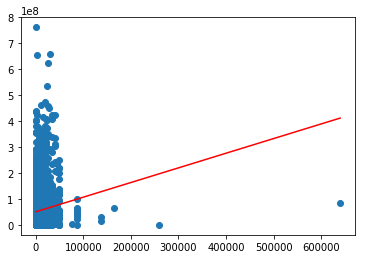

In [13]:
#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_actor1_likes = int(movies_df.actor_1_facebook_likes.max())

a1, b1 = np.polyfit(movies_df.actor_1_facebook_likes, movies_df.gross, 1)

pred_likes1_list = list()
for i in range(0, max_actor1_likes):
    pred_likes1_list.append((a1 * i) + b1)

pred_likes1 = np.array(pred_likes1_list)

plt.scatter(movies_df.actor_1_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor1_likes), pred_likes1, color='red')

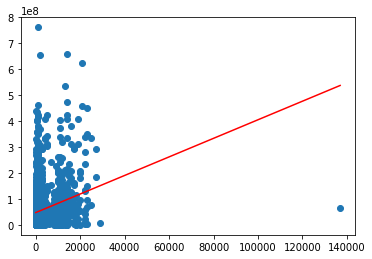

In [14]:
#Scatterplot for actor2_facebook_likes and movie gross with regression line
#max actor_2 likes
max_actor2_likes = int(movies_df.actor_2_facebook_likes.max())

a2, b2 = np.polyfit(movies_df.actor_2_facebook_likes, movies_df.gross, 1)

pred_likes2_list = list()
for i in range(0, max_actor2_likes):
    pred_likes2_list.append((a2 * i) + b2)

pred_likes2 = np.array(pred_likes2_list)

plt.scatter(movies_df.actor_2_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor2_likes), pred_likes2, color='red')

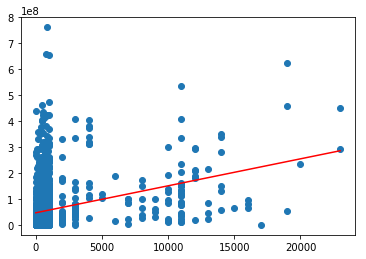

In [15]:
#Scatterplot for actor3_facebook_likes and movie gross with regression line
#max actor_3 likes
max_actor3_likes = int(movies_df.actor_3_facebook_likes.max())

a3, b3 = np.polyfit(movies_df.actor_3_facebook_likes, movies_df.gross, 1)

pred_likes3_list = list()
for i in range(0, max_actor3_likes):
    pred_likes3_list.append((a3 * i) + b3)

pred_likes3 = np.array(pred_likes3_list)

plt.scatter(movies_df.actor_3_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor3_likes), pred_likes3, color='red')

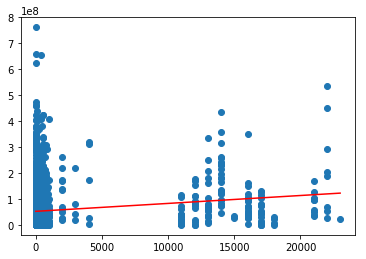

In [16]:
#Scatterplot for director_facebook_likes and movie gross with regression line
#max director likes
max_director_likes = int(movies_df.director_facebook_likes.max())

a, b = np.polyfit(movies_df.director_facebook_likes, movies_df.gross, 1)

pred_likes_list = list()
for i in range(0, max_director_likes):
    pred_likes_list.append((a * i) + b)

pred_likes = np.array(pred_likes_list)

plt.scatter(movies_df.director_facebook_likes, movies_df.gross)

plt.plot(range(0, max_director_likes), pred_likes, color='red')

The scatterplots demonstrate a positive correlation between facebook likes and movie gross income. However, the distributions are clustered and therefore need to be transformed for a desired normal distribution.. From this, we decided to use a log transformation.

In [17]:
#having any 0 likes affects log transformation
movies_df[(movies_df.actor_1_facebook_likes == 0) |
          (movies_df.actor_2_facebook_likes == 0) |
          (movies_df.actor_3_facebook_likes == 0) |
          (movies_df.director_facebook_likes == 0)].count()

movie_title                550
title_year                 550
gross                      550
director_name              550
director_facebook_likes    550
actor_1_name               550
actor_1_facebook_likes     550
actor_2_name               550
actor_2_facebook_likes     550
actor_3_name               550
actor_3_facebook_likes     550
genres                     550
dtype: int64

In [18]:
#add .1 weight to all likes
movies_df.actor_1_facebook_likes = (
    movies_df.actor_1_facebook_likes.apply(lambda x: x+.1))
movies_df.actor_2_facebook_likes = (
    movies_df.actor_2_facebook_likes.apply(lambda x: x+.1))
movies_df.actor_3_facebook_likes = (
    movies_df.actor_3_facebook_likes.apply(lambda x: x+.1))
movies_df.director_facebook_likes = (
    movies_df.director_facebook_likes.apply(lambda x: x+.1))

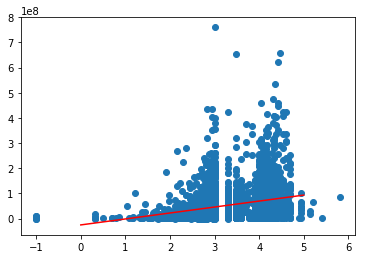

In [19]:
#Changing like values of actor 1 using log10
movies_df['actor_1_facebook_likes_log'] = (
    np.log10(movies_df['actor_1_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor1_likes = movies_df.actor_1_facebook_likes_log.max()

a1, b1 = (
    np.polyfit(movies_df.actor_1_facebook_likes_log, movies_df.gross, 1))

pred_loglikes1_list = list()
for i in np.arange(0, max_logactor1_likes):
    pred_loglikes1_list.append((a1 * i) + b1)

pred_loglikes1 = np.array(pred_loglikes1_list)

plt.scatter(movies_df.actor_1_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor1_likes), pred_loglikes1, color='red')

In [20]:
#Regression Model for actor 1 likes and gross income of movie
outcome_1, predictors_1 = (
    patsy.dmatrices('gross ~ actor_1_facebook_likes_log', movies_df))
mod_1 = sm.OLS (outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     205.8
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           3.03e-45
Time:                        16:22:11   Log-Likelihood:                -60699.
No. Observations:                3118   AIC:                         1.214e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

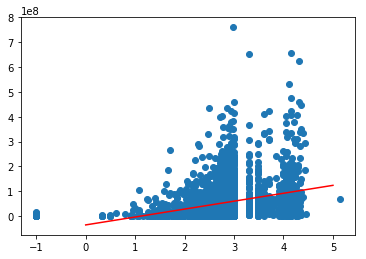

In [21]:
#Changing like values of actor 2 using log10
movies_df['actor_2_facebook_likes_log'] = (
    np.log10(movies_df['actor_2_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor2_likes = movies_df.actor_2_facebook_likes_log.max()

a2, b2 = (
    np.polyfit(movies_df.actor_2_facebook_likes_log, movies_df.gross, 1))

pred_loglikes2_list = list()
for i in np.arange(0, max_logactor2_likes):
    pred_loglikes2_list.append((a2 * i) + b2)

pred_loglikes2 = np.array(pred_loglikes2_list)

plt.scatter(movies_df.actor_2_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor2_likes), pred_loglikes2, color='red')

In [22]:
#Regression Model for actor 2 likes and gross income of movie
outcome_2, predictors_2 = (
    patsy.dmatrices('gross ~ actor_2_facebook_likes_log + Action + ....', movies_df))
mod_2 = sm.OLS (outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     275.0
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           2.97e-59
Time:                        16:22:11   Log-Likelihood:                -60667.
No. Observations:                3118   AIC:                         1.213e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

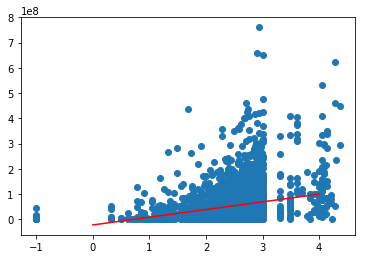

In [23]:
#Changing like values of actor 3 using log10
movies_df['actor_3_facebook_likes_log'] = (
    np.log10(movies_df['actor_3_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor3_likes = movies_df.actor_3_facebook_likes_log.max()

a3, b3 = (
    np.polyfit(movies_df.actor_3_facebook_likes_log, movies_df.gross, 1))

pred_loglikes3_list = list()
for i in np.arange(0, max_logactor3_likes):
    pred_loglikes3_list.append((a3 * i) + b3)

pred_loglikes3 = np.array(pred_loglikes3_list)

plt.scatter(movies_df.actor_3_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor3_likes), pred_loglikes3, color='red')

In [24]:
#Regression Model for actor 1 likes and gross income of movie
outcome_3, predictors_3 = (
    patsy.dmatrices('gross ~ actor_3_facebook_likes_log', movies_df))
mod_3 = sm.OLS (outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           1.64e-50
Time:                        16:22:11   Log-Likelihood:                -60687.
No. Observations:                3118   AIC:                         1.214e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

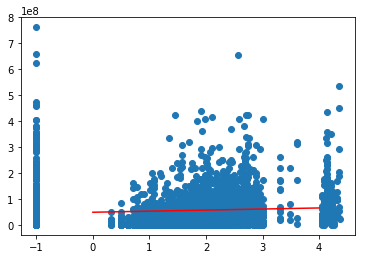

In [25]:
#Changing like values of director likes using log10
movies_df['director_facebook_likes_log'] = (
    np.log10(movies_df['director_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logdirector_likes = movies_df.director_facebook_likes_log.max()

a, b = (
    np.polyfit(movies_df.director_facebook_likes_log, movies_df.gross, 1))

pred_loglikes_list = list()
for i in np.arange(0, max_logdirector_likes):
    pred_loglikes_list.append((a * i) + b)

pred_loglikes = np.array(pred_loglikes_list)

plt.scatter(movies_df.director_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logdirector_likes), pred_loglikes, color='red')

In [26]:
#Regression Model for actor 1 likes and gross income of movie
outcome, predictors = (
    patsy.dmatrices('gross ~ director_facebook_likes_log', movies_df))
mod = sm.OLS (outcome,predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     19.28
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           1.16e-05
Time:                        16:22:12   Log-Likelihood:                -60789.
No. Observations:                3118   AIC:                         1.216e+05
Df Residuals:                    3116   BIC:                         1.216e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [27]:
#stats for actor 1 likes with gross
slope1, intercept1, r1_value, p1_value, std_err = (
    stats.linregress(movies_df['actor_1_facebook_likes'],
                     movies_df['gross']))
print(r1_value)
slope1, intercept1, r1_value, p1_value, std_err = (
    stats.linregress(movies_df['actor_1_facebook_likes_log'],
                     movies_df['gross']))
print(r1_value)

0.131226566551
0.248908538817


The log transformation has an effect on increasing the r-value. There is a slight increase in the correlation between likes to gross income. However, the correlation is still substantially weak.

In [28]:
#stats for actor 2 likes with gross
slope2, intercept2, r2_value, p2_value, std_err = (
    stats.linregress(movies_df['actor_2_facebook_likes'],
                     movies_df['gross']))
print(r2_value)
slope2, intercept2, r2_value, p2_value, std_err = (
    stats.linregress(movies_df['actor_2_facebook_likes_log'],
                     movies_df['gross']))
print(r2_value)

0.234651474653
0.284775272266


In [29]:
#stats for actor 3 likes with gross
slope3, intercept1, r3_value, p3_value, std_err = (
    stats.linregress(movies_df['actor_3_facebook_likes'],
                     movies_df['gross']))
print(r3_value)
slope3, intercept1, r3_value, p3_value, std_err = (
    stats.linregress(movies_df['actor_3_facebook_likes_log'],
                     movies_df['gross']))
print(r3_value)

0.277002366879
0.263052701147


In [30]:
#stats for director likes with gross
slope, intercept, r_value, p_value, std_err = (
    stats.linregress(movies_df['director_facebook_likes'],
                     movies_df['gross']))
print(r_value)
slope, intercept, r_value, p_value, std_err = (
    stats.linregress(movies_df['director_facebook_likes_log'],
                     movies_df['gross']))
print(r_value)

0.140597681431
0.0784245980429


[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

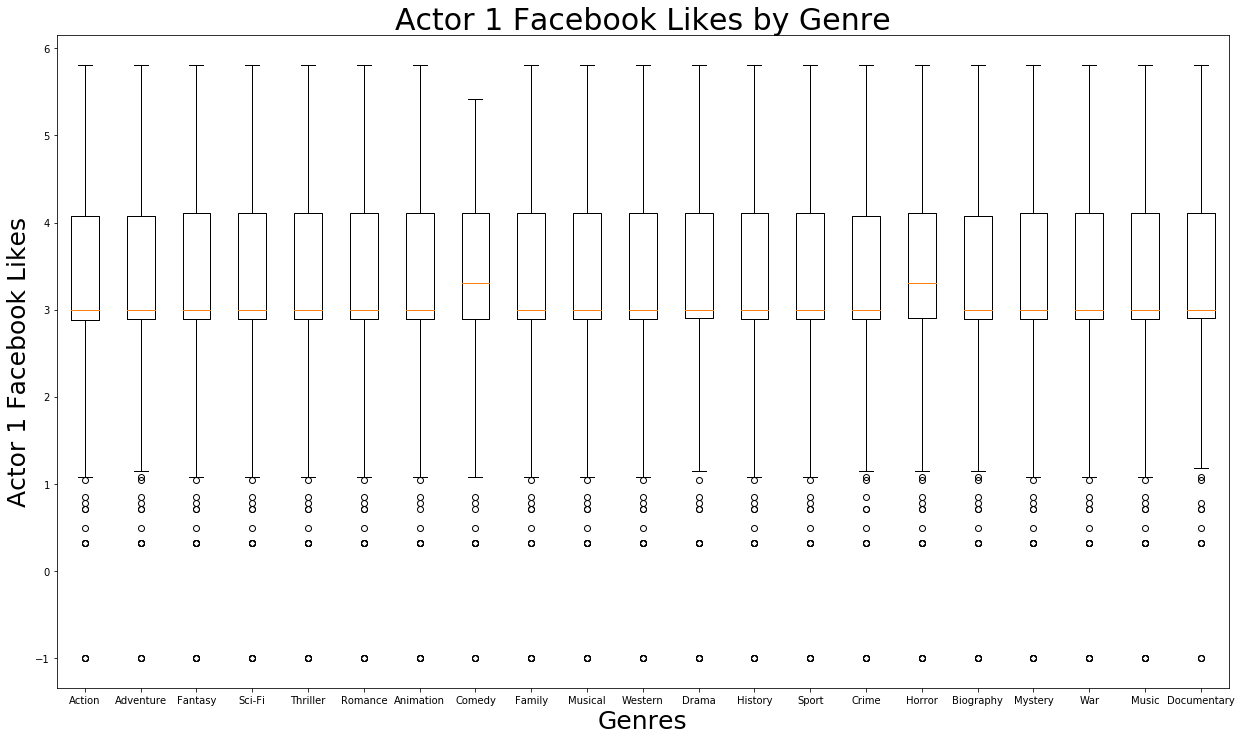

In [31]:
#Add all actor1 likes into its respective list

action1 = []
adventure1 = []
fantasy1 = []
scifi1 = []
thriller1 = []
romance1 = []
animation1 = []
comedy1 = []
family1 = []
musical1 = []
western1 = []
drama1 = []
history1 = []
sport1 = []
crime1 = []
horror1 = []
biography1 = []
mystery1 = []
war1 = []
music1 = []
documentary1 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_1_facebook_likes_log']
    if (rows['genres'].find('Action')):
        action1.append(currLikes)
    if (rows['genres'].find('Adventure')):
        adventure1.append(currLikes)
    if (rows['genres'].find('Fantasy')):
        fantasy1.append(currLikes)
    if (rows['genres'].find('Sci-Fi')):
        scifi1.append(currLikes)
    if (rows['genres'].find('Thriller')):
        thriller1.append(currLikes)
    if (rows['genres'].find('Romance')):
        romance1.append(currLikes)
    if (rows['genres'].find('Animation')):
        animation1.append(currLikes)
    if (rows['genres'].find('Comedy')):
        comedy1.append(currLikes)
    if (rows['genres'].find('Family')):
        family1.append(currLikes)
    if (rows['genres'].find('Musical')):
        musical1.append(currLikes)
    if (rows['genres'].find('Western')):
        western1.append(currLikes)
    if (rows['genres'].find('Drama')):
        drama1.append(currLikes)
    if (rows['genres'].find('History')):
        history1.append(currLikes)
    if (rows['genres'].find('Sport')):
        sport1.append(currLikes)
    if (rows['genres'].find('Crime')):
        crime1.append(currLikes)
    if (rows['genres'].find('Horror')):
        horror1.append(currLikes)
    if (rows['genres'].find('Biography')):
        biography1.append(currLikes)
    if (rows['genres'].find('Mystery')):
        mystery1.append(currLikes)
    if (rows['genres'].find('War')):
        war1.append(currLikes)
    if (rows['genres'].find('Music')):
        music1.append(currLikes)
    if (rows['genres'].find('Documentary')):
        documentary1.append(currLikes)
        
        
actor1Likes = [action1, adventure1, fantasy1, scifi1, thriller1, romance1, animation1,
               comedy1,family1 ,musical1 ,western1, drama1, history1 , sport1 , crime1 ,
               horror1, biography1 , mystery1 , war1 , music1 ,documentary1]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = plt.boxplot(actor1Likes)

ax.set_title('Actor 1 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 1 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

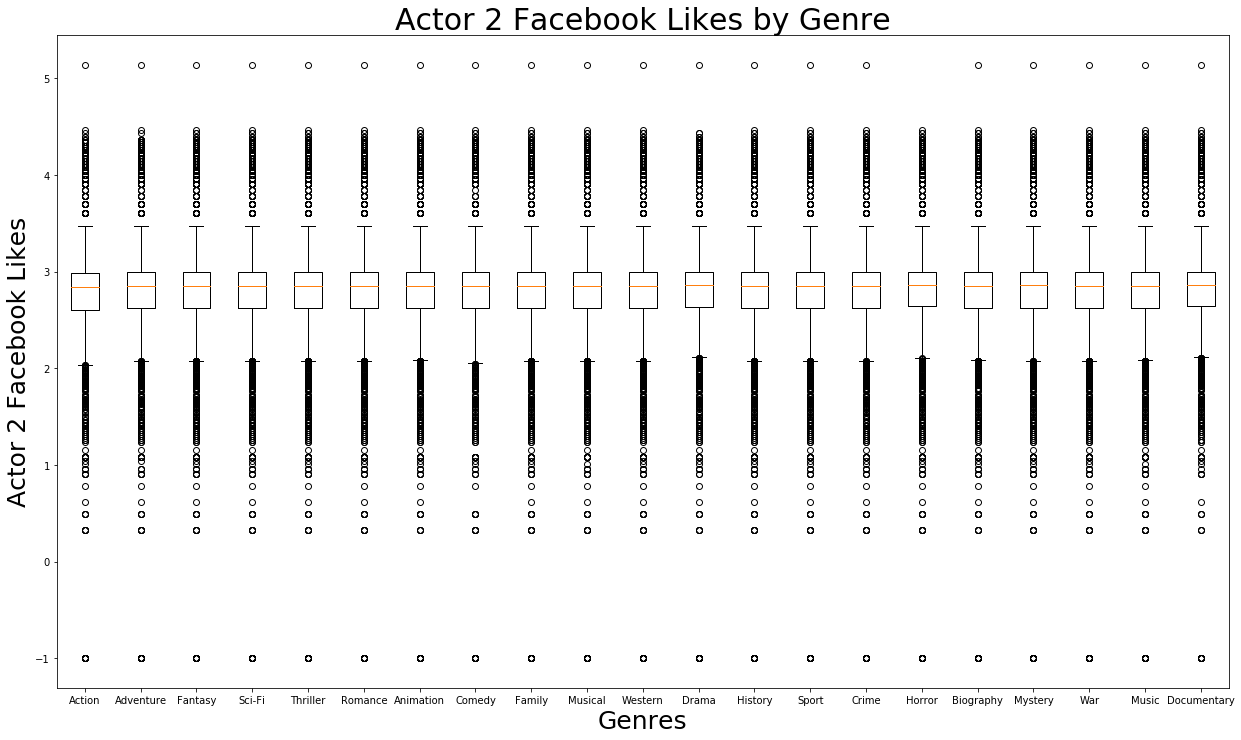

In [32]:
#Add all actor2 likes into its respective list

action2 = []
adventure2 = []
fantasy2 = []
scifi2 = []
thriller2 = []
romance2 = []
animation2 = []
comedy2 = []
family2 = []
musical2 = []
western2 = []
drama2 = []
history2 = []
sport2 = []
crime2 = []
horror2 = []
biography2 = []
mystery2 = []
war2 = []
music2 = []
documentary2 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_2_facebook_likes_log']
    if (rows['genres'].find('Action')):
        action2.append(currLikes)
    if (rows['genres'].find('Adventure')):
        adventure2.append(currLikes)
    if (rows['genres'].find('Fantasy')):
        fantasy2.append(currLikes)
    if (rows['genres'].find('Sci-Fi')):
        scifi2.append(currLikes)
    if (rows['genres'].find('Thriller')):
        thriller2.append(currLikes)
    if (rows['genres'].find('Romance')):
        romance2.append(currLikes)
    if (rows['genres'].find('Animation')):
        animation2.append(currLikes)
    if (rows['genres'].find('Comedy')):
        comedy2.append(currLikes)
    if (rows['genres'].find('Family')):
        family2.append(currLikes)
    if (rows['genres'].find('Musical')):
        musical2.append(currLikes)
    if (rows['genres'].find('Western')):
        western2.append(currLikes)
    if (rows['genres'].find('Drama')):
        drama2.append(currLikes)
    if (rows['genres'].find('History')):
        history2.append(currLikes)
    if (rows['genres'].find('Sport')):
        sport2.append(currLikes)
    if (rows['genres'].find('Crime')):
        crime2.append(currLikes)
    if (rows['genres'].find('Horror')):
        horror2.append(currLikes)
    if (rows['genres'].find('Biography')):
        biography2.append(currLikes)
    if (rows['genres'].find('Mystery')):
        mystery2.append(currLikes)
    if (rows['genres'].find('War')):
        war2.append(currLikes)
    if (rows['genres'].find('Music')):
        music2.append(currLikes)
    if (rows['genres'].find('Documentary')):
        documentary2.append(currLikes)
        
        
actor2Likes = [action2, adventure2, fantasy2, scifi2, thriller2, romance2, animation2,
               comedy2,family2 ,musical2 ,western2, drama2, history2 , sport2 , crime2 ,
               horror2, biography2 , mystery2 , war2 , music2 ,documentary2]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = ax.boxplot(actor2Likes)

ax.set_title('Actor 2 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 2 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

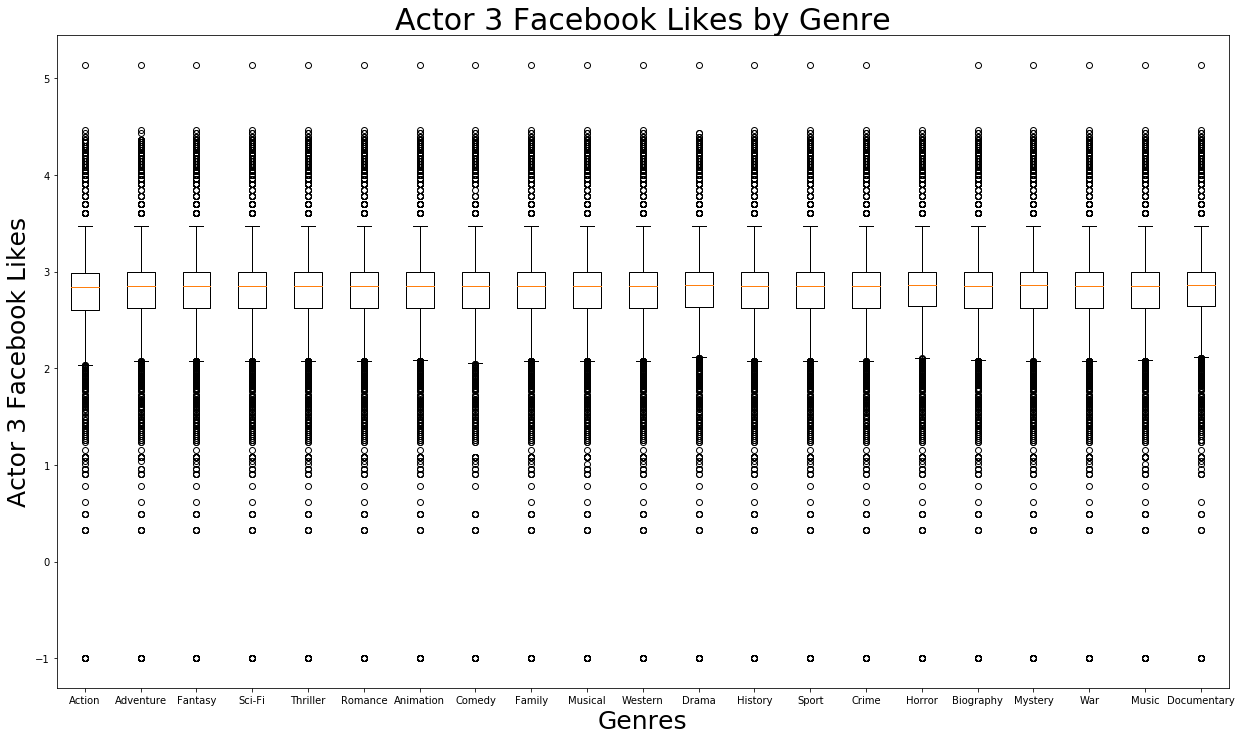

In [33]:
#Add all actor3 likes into its respective list

action3 = []
adventure3 = []
fantasy3 = []
scifi3 = []
thriller3 = []
romance3 = []
animation3 = []
comedy3 = []
family3 = []
musical3 = []
western3 = []
drama3 = []
history3 = []
sport3 = []
crime3 = []
horror3 = []
biography3 = []
mystery3 = []
war3 = []
music3 = []
documentary3 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_3_facebook_likes_log']
    if (rows['genres'].find('Action')):
        action3.append(currLikes)
    if (rows['genres'].find('Adventure')):
        adventure3.append(currLikes)
    if (rows['genres'].find('Fantasy')):
        fantasy3.append(currLikes)
    if (rows['genres'].find('Sci-Fi')):
        scifi3.append(currLikes)
    if (rows['genres'].find('Thriller')):
        thriller3.append(currLikes)
    if (rows['genres'].find('Romance')):
        romance3.append(currLikes)
    if (rows['genres'].find('Animation')):
        animation3.append(currLikes)
    if (rows['genres'].find('Comedy')):
        comedy3.append(currLikes)
    if (rows['genres'].find('Family')):
        family3.append(currLikes)
    if (rows['genres'].find('Musical')):
        musical3.append(currLikes)
    if (rows['genres'].find('Western')):
        western3.append(currLikes)
    if (rows['genres'].find('Drama')):
        drama3.append(currLikes)
    if (rows['genres'].find('History')):
        history3.append(currLikes)
    if (rows['genres'].find('Sport')):
        sport3.append(currLikes)
    if (rows['genres'].find('Crime')):
        crime3.append(currLikes)
    if (rows['genres'].find('Horror')):
        horror3.append(currLikes)
    if (rows['genres'].find('Biography')):
        biography3.append(currLikes)
    if (rows['genres'].find('Mystery')):
        mystery3.append(currLikes)
    if (rows['genres'].find('War')):
        war3.append(currLikes)
    if (rows['genres'].find('Music')):
        music3.append(currLikes)
    if (rows['genres'].find('Documentary')):
        documentary3.append(currLikes)
        
        
actor3Likes = [action3, adventure3, fantasy3, scifi3, thriller3, romance3, animation3,
               comedy3,family3 ,musical3 ,western3, drama3, history3 , sport3 , crime3 ,
               horror3, biography3 , mystery3 , war3 , music3 ,documentary3]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = ax.boxplot(actor2Likes)

ax.set_title('Actor 3 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 3 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

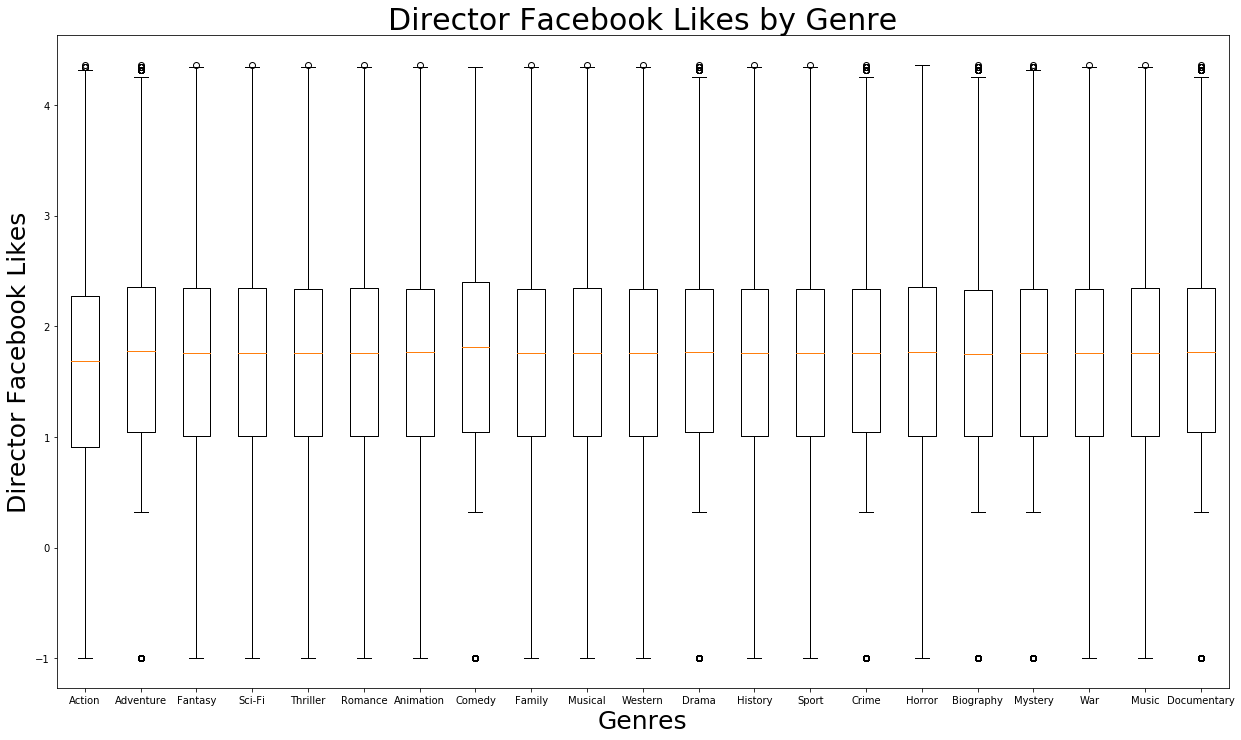

In [34]:
#Add all actor1 likes into its respective list

actionD = []
adventureD = []
fantasyD = []
scifiD = []
thrillerD = []
romanceD = []
animationD = []
comedyD = []
familyD = []
musicalD = []
westernD = []
dramaD = []
historyD = []
sportD = []
crimeD = []
horrorD = []
biographyD = []
mysteryD = []
warD = []
musicD = []
documentaryD = []


for i, rows in movies_df.iterrows():
    currLikes = rows['director_facebook_likes_log']
    if (rows['genres'].find('Action')):
        actionD.append(currLikes)
    if (rows['genres'].find('Adventure')):
        adventureD.append(currLikes)
    if (rows['genres'].find('Fantasy')):
        fantasyD.append(currLikes)
    if (rows['genres'].find('Sci-Fi')):
        scifiD.append(currLikes)
    if (rows['genres'].find('Thriller')):
        thrillerD.append(currLikes)
    if (rows['genres'].find('Romance')):
        romanceD.append(currLikes)
    if (rows['genres'].find('Animation')):
        animationD.append(currLikes)
    if (rows['genres'].find('Comedy')):
        comedyD.append(currLikes)
    if (rows['genres'].find('Family')):
        familyD.append(currLikes)
    if (rows['genres'].find('Musical')):
        musicalD.append(currLikes)
    if (rows['genres'].find('Western')):
        westernD.append(currLikes)
    if (rows['genres'].find('Drama')):
        dramaD.append(currLikes)
    if (rows['genres'].find('History')):
        historyD.append(currLikes)
    if (rows['genres'].find('Sport')):
        sportD.append(currLikes)
    if (rows['genres'].find('Crime')):
        crimeD.append(currLikes)
    if (rows['genres'].find('Horror')):
        horrorD.append(currLikes)
    if (rows['genres'].find('Biography')):
        biographyD.append(currLikes)
    if (rows['genres'].find('Mystery')):
        mysteryD.append(currLikes)
    if (rows['genres'].find('War')):
        warD.append(currLikes)
    if (rows['genres'].find('Music')):
        musicD.append(currLikes)
    if (rows['genres'].find('Documentary')):
        documentaryD.append(currLikes)
        
        
actorDLikes = [actionD, adventureD, fantasyD, scifiD, thrillerD, romanceD, animationD,
               comedyD,familyD ,musicalD ,westernD, dramaD, historyD , sportD , crimeD ,
               horrorD, biographyD , mysteryD , warD , musicD ,documentaryD]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = plt.boxplot(actorDLikes)

ax.set_title('Director Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Director Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])